In [3]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import numpy as np

In [13]:
#---tarih ayarlari---#
# suana kadar gecen gun
total_day_of_year = datetime.now().timetuple().tm_yday 
# bulundugumuz yil
year = datetime.now().year  
old_year_day_max = 0
old_year = 0
# son kac gun alinacak, 2 taraf da dahil.
last_x_day = 15
# toplam gun, son x gunden kucukse (yeni yilin ilk gunleri)
if total_day_of_year < last_x_day:
    old_year = year - 1
    old_year_day_max = 366 if old_year % 4 == 0 else 365  #subat 29 durumu
    #onceki yildan alinacak gun
    old_year_day = old_year_day_max - (last_x_day - total_day_of_year)

In [5]:
#---grafik ayarlari---#
day_interval = 1 # x barinda tarih gozukme araligi
hour_interval = 1 # y barinda saat gozukme araligi

In [6]:
f = open('UA0B.txt','r')
df = pd.DataFrame(columns=['subsystem_name','date'])
line = f.readline()

In [7]:
#parse bolumu, tarih saat sistem adi ceker
archive_log = False
sub_system_name = ''
count = 0
dic = {}
while line:
    #data sharing grup adini alir
    if line[12:23] == 'GROUP NAME:':
        group_name = line[39:46]
    # member adini alir
    if line[16:64] == 'LOG MAP OF THE BSDS DATA SET BELONGING TO MEMBER':  
        # yeni membera gectiginde parametreleri 0lar
        if sub_system_name != '':  
            dic[sub_system_name] = count
            count = 0
        sub_system_name = line[66:70]
    #duplicatei onlemek icin sadece tek copyi alir.
    if line[1:19] == 'ARCHIVE LOG COPY 1':
        archive_log = True
    #duplicatei onlemek icin sadece tek copyi alir.
    if line[1:18] == 'ACTIVE LOG COPY 1' or line[1:18] == 'ACTIVE LOG COPY 2' :
        archive_log = False
    # tarih ve zaman alir
    if line[2:11] == '000000000':
        if (archive_log and 
        (int(line[50:54]) == year and 
        int(line[55:58]) <= total_day_of_year and 
        int(line[55:58]) >= total_day_of_year - last_x_day)
        or
        (int(line[50:54]) == old_year and
        int(line[55:58]) <= old_year_day_max and
        int(line[55:58]) >= old_year_day)):
            count += 1
            date=line[50:58]+'T'
            line = f.readline()
            time=line[52:57].strip()
            df.loc[len(df)] = {'subsystem_name':sub_system_name,
                               'date':datetime.strptime(date+time,'%Y.%jT%H:%M')}
    line = f.readline()
dic[sub_system_name] = count
f.close()
print(dic)
print(df)

{'UA1B': 0, 'UA2B': 0, 'UA3B': 0, 'UA4B': 0}
Empty DataFrame
Columns: [subsystem_name, date]
Index: []


In [8]:
#tarih ve zamani ayirma
df['time'] = [str(i).split()[1] for i in df.date]
df['date'] = [str(i).split()[0] for i in df.date]
#grup adini dsn ekinden ayirma
if group_name[:3] == 'DSN': group_name = group_name[3:]

In [9]:
#tarih - zaman formatlari
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['time'] = [ i[:5]  for i in df.time]
df['time'] = pd.to_datetime(df['time'], format='%H:%M')
df.head(15)

,subsystem_name,date,time


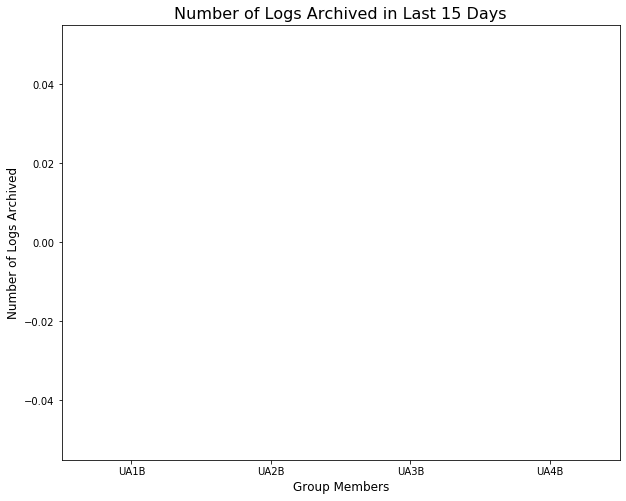

In [10]:
#count bar plot
names = list(dic.keys())
values = list(dic.values())

plt.figure(figsize=(10,8))
sns.barplot(x=names,y=values)
plt.ylabel('Number of Logs Archived',fontsize=12)
plt.xlabel('Group Members',fontsize=12)
plt.title('Number of Logs Archived in Last ' + str(last_x_day) + ' Days', fontsize=16)
plt.show()

In [11]:
# sure bazli total scatter plot
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(df.date, df.time, color = 'yellow', alpha=0.7, mec='black')
plt.xticks(df.date,rotation = '75')
yfmt = mdates.DateFormatter('%H:%M') 
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(yfmt)
ax.yaxis.set_major_locator(mdates.HourLocator(interval=hour_interval)) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=day_interval))
plt.xlabel('DATE ---->')
plt.ylabel('TIME ---->')
plt.title('Group ' + group_name + ' All Members Last ' + str(last_x_day) + ' Days (Archived Logs)')
plt.style.use('bmh')
plt.tick_params(left = False, bottom = False, labelsize = 10)
plt.rcParams["font.size"] = "12"

plt.show()


/Users/gokalp/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


RuntimeError: Locator attempting to generate 4018 ticks from 729938.0 to 733955.0: exceeds Locator.MAXTICKS

In [ ]:
#her member icin sure bazli scatter plot
for sys in df.subsystem_name.unique():
    df_sys = df[df.subsystem_name == sys].copy()
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot_date(df_sys.date, df_sys.time, color = 'red', alpha=0.7, mec='black') #Plot the data
    plt.xticks(df_sys.date,rotation = '75')
    yfmt = mdates.DateFormatter('%H:%M') 
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(yfmt)
    ax.yaxis.set_major_locator(mdates.HourLocator(interval=hour_interval))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=day_interval))
    plt.xlabel('DATE ---->')
    plt.ylabel('TIME ---->')
    plt.title(df_sys.subsystem_name.iloc[0] + ' Member Last ' + str(last_x_day) + ' Days (Archived Logs)')
    plt.style.use('bmh')
    plt.tick_params(left = False, bottom = False, labelsize = 10) 
    plt.rcParams["font.size"] = "12" 

    plt.show()

In [ ]:
# butun memberlerin countlari group bar plot
plt.figure(figsize=(15,12))
ax = df.groupby('date').subsystem_name.value_counts().unstack().plot.bar(width=0.75,color=["b","g","r","c"])
plt.gcf().set_size_inches(15, 8)
plt.xlabel('DATE ---->')
plt.ylabel('Count')
plt.title('Archived Logs Trend Last ' + str(last_x_day) + ' Days',size=20)
plt.xticks(rotation = '75')
plt.show()